<a href="https://colab.research.google.com/github/Suchitra-V31/Deep_Learning_Projects/blob/main/PCB_Defect_detection_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PCB Defect detection and classification**

Printed Circuit Boards (PCB) are the functional building block of most modern electronic devices. PCB’s are prone to variety of defects that disrupt proper manufacturing and results in high cost. 


 To overcome such kinds of difficulties and issues , a deep learning based automatic detection and classification application is developed.

**Let us import all the necessary libraries**

In [1]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

We are going to define the image size, width and height - the parameters that are requird in the training phase. 

In [2]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

**Data Collection And EDA**

The dataset is collected from **GitHub** which consists of **1195** images which can able to classify PCB images into **Good** and **Bad**. 

If the PCB does not has any defect ,then it is considered as good else if the PCB images has fault it is categorized as Bad.

In [3]:
filenames = os.listdir(r"/content/drive/MyDrive/Datasets/dataset/train/train5")
labels = []

for filename in filenames:
    label = filename.split(' ')[0]
    if label == 'good':
        labels.append(0)
    else:
        labels.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

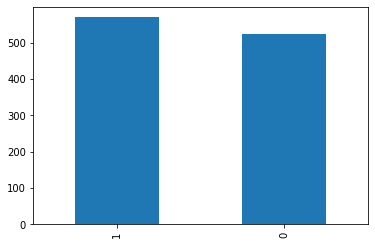

In [4]:
df['label'].value_counts().plot.bar()

**Create Model**


A DL-based detector utilizes a **Mobilenet** with deep convolutional neural network (CNN) to extract and defect features and learn inherent patterns of defects, automatically, with standard images.


Some additional Dense layers are also added into the model inorder to increase the performance of the model.


In [7]:
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)                       
x=Dense(1024,activation='relu')(x)                          
x=Dense(512,activation='relu')(x)                           
preds=Dense(2,activation='softmax')(x)             

17235968/17225924 [==============================] - 0s 0us/step


In [8]:
model=Model(inputs=base_model.input,outputs=preds)

**Compile our Model**

In [25]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy']) 

The data is split into training and validating phase

In [26]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [27]:
earlystop = EarlyStopping(patience=10)


In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [29]:
callbacks = [earlystop, learning_rate_reduction]

In [30]:
df["label"] = df["label"].replace({0: 'Good', 1: 'Bad'}) 

In [31]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

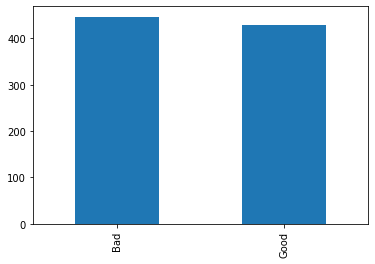

In [32]:
train_df['label'].value_counts().plot.bar()

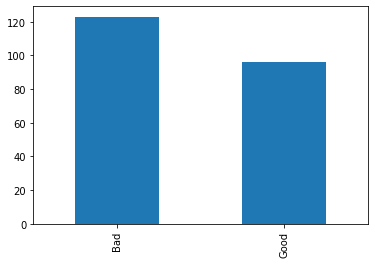

In [33]:
validate_df['label'].value_counts().plot.bar()

In [34]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Using **Data Augmentation** the the existing data is altered to create some more data for the model training process

In [35]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"/content/drive/MyDrive/Datasets/dataset/train/train5", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 876 validated image filenames belonging to 2 classes.


In [36]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"/content/drive/MyDrive/Datasets/dataset/train/train5", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)    

Found 219 validated image filenames belonging to 2 classes.


**TRAIN!!!!!!**

In [42]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
58/58 [==============================] - 125s 2s/step - loss: 0.0195 - accuracy: 0.9919 - val_loss: 0.0392 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 2/50
58/58 [==============================] - 122s 2s/step - loss: 0.0159 - accuracy: 0.9965 - val_loss: 0.0399 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 3/50
58/58 [==============================] - 122s 2s/step - loss: 0.0313 - accuracy: 0.9919 - val_loss: 0.0418 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 4/50
58/58 [==============================] - 123s 2s/step - loss: 0.0133 - accuracy: 0.9942 - val_loss: 0.0425 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 5/50
58/58 [==============================] - 123s 2s/step - loss: 0.0296 - accuracy: 0.9919 - val_loss: 0.0417 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 6/50
58/58 [==============================] - 123s 2s/step - loss: 0.0158 - accuracy: 0.9942 - val_loss: 0.0416 - val_accuracy: 0.9905 - lr: 1.0000e-05
Epoch 7/50
58/58 [==============================] - 

Our Model has performed with **99.6%** accuracy.

**Save our Model**

In [43]:
model.save_weights("model.h5")

In [64]:
model.save('/content/drive/My Drive/Datasets/dataset/model.h5')

**Testing our images with the test data**

In [65]:
import cv2
img = cv2.imread(r'/content/drive/MyDrive/Datasets/dataset/test/test5/good (277)k.jpeg')
img = img[...,::-1]                                                                 #give right image or else it will show error
model.predict(img[None,...], batch_size=None, verbose=2, steps=1)

1/1 - 0s - 55ms/epoch - 55ms/step


array([[0.4526682, 0.5473318]], dtype=float32)

In [48]:
test_filenames = os.listdir(r"/content/drive/MyDrive/Datasets/dataset/test/test5")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [49]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    r"/content/drive/MyDrive/Datasets/dataset/test/test5", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 100 validated image filenames.


In [50]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [51]:
test_df['label'] = np.argmax(predict, axis=-1)

In [52]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

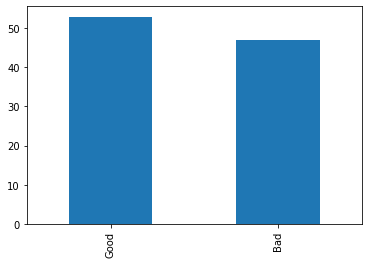

In [53]:
test_df['label'].value_counts().plot.bar()

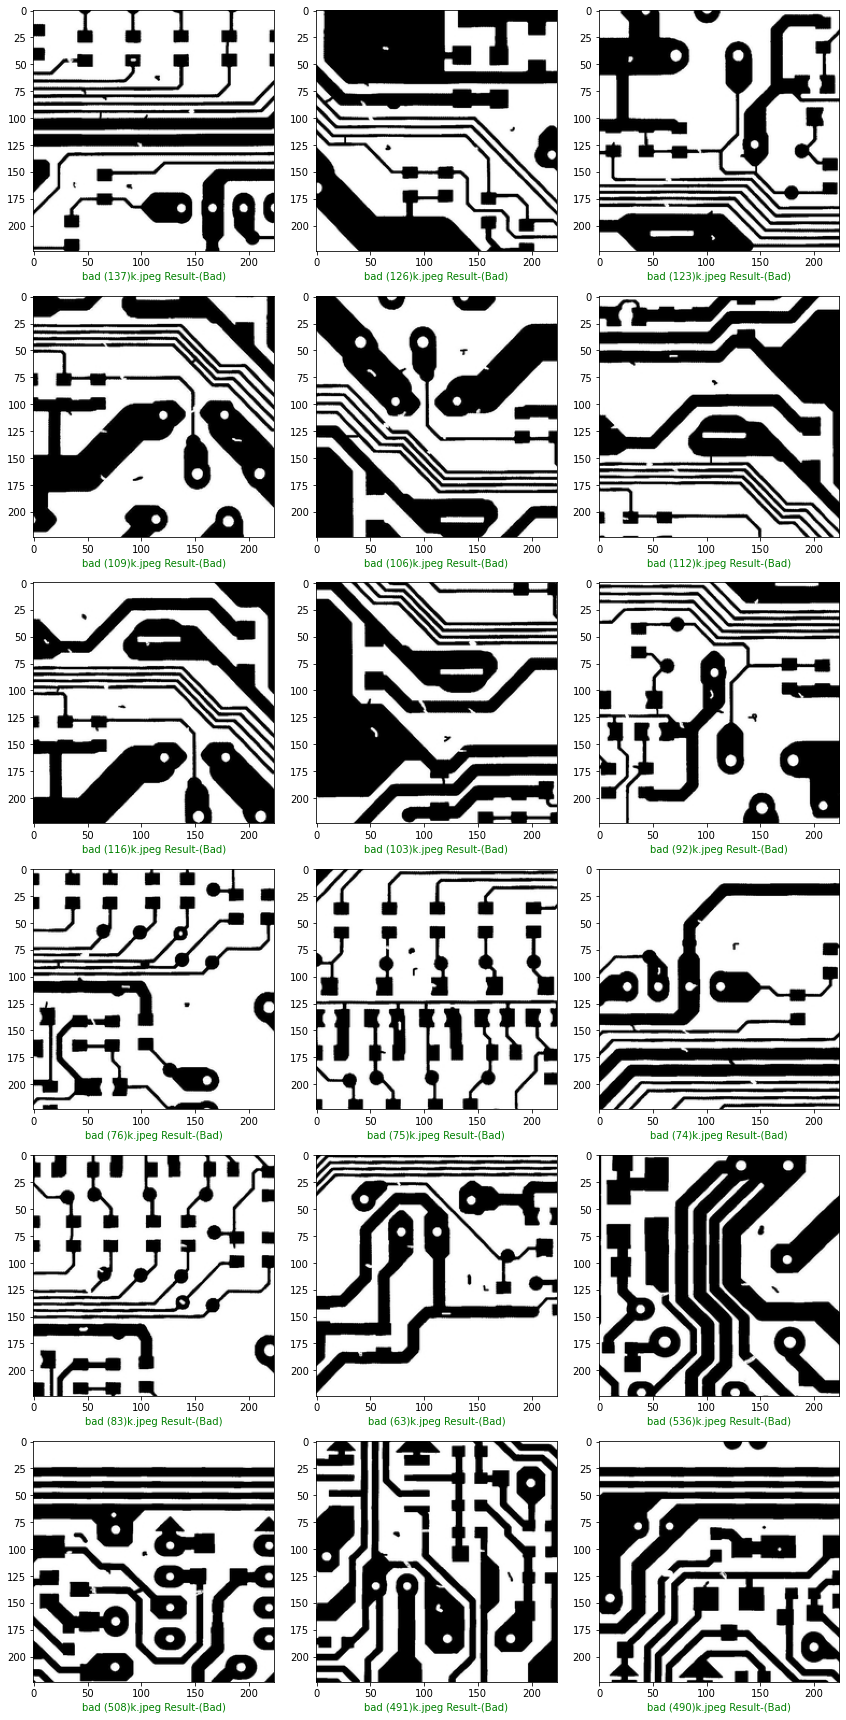

In [63]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img(r"/content/drive/MyDrive/Datasets/dataset/test/test5/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + (' ') + 'Result-' + '(' + "{}".format(category) + ')' ,color='green')
plt.tight_layout()
plt.show()

We could see that our model has performed well in the testing phase and have also  predicted all the images correctly.